In [1]:
%%javascript to enable numbering of the equations below -- ignore this cell
MathJax.Hub.Config({TeX: { equationNumbers: { autoNumber: "AMS" } }});

<IPython.core.display.Javascript object>

# Vehicle control - problem definition

![graphical representation of the problem](./Images/vehicle-model.png "vehicle control - problem definition")

This notebook presents the problem of controlling the speed of a car travelling in the Alps. The notebook will go through two different types of automatic controllers, making the reader comparing them and thinking at why they are different.

#### Notation:

- $t$ = time

- $u(t)$ = force produced by the engine and transmitted to the road through the wheels at time $t$
- $x(t)$ = position of the car at time $t$
- $\dot{x}(t)$ = velocity of the car at time $t$
- $\ddot{x}(t)$ = acceleration of the car at time $t$

- $d(x)$ = slope of the street at position $x$ (in radiants)
- $m$ = mass of the vehicle (constant)
- $b$ = viscous friction coefficient (constant)
- $g$ = gravitational acceleration (constant)

#### Assumptions:

- the vehicle is modelled as a point mass subject to gravity and friction effects
- $u$ is the controllable force produced by its engine
- $d$ is the inclination of the road (and it is a latent variable)
- the bigger $|d|$, the bigger the effects of gravity on the motion of the vehicle
- the bigger the velocity of the vehicle, the bigger the frictions will be

#### The problem:

design $u(t)$ so that the velocity of the vehicle follows a certain given reference signal $r(t)$ independently of the road profile $d(x)$ and the friction affecting the vehicle.

## Simulating the system by modelling its dynamics

Using classical Newtonian mechanics considerations leads to

\begin{equation}
    m \ddot{x}(t) = - b \dot{x}(t) + u(t) - m g \sin \Big( d \big( x(t) \big) \Big) .
\end{equation}

One can then simulate the system as below.

<Figure size 432x288 with 0 Axes>

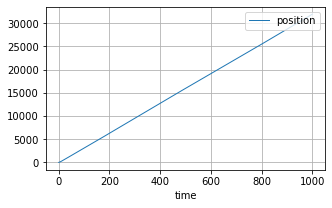

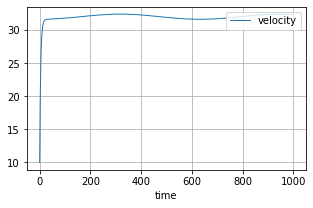

In [2]:
# load the necessary packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# model parameters
g = 9.8
b = 0.1
m = 0.4

# define the function that gets the vector X of states x_i, and
# a vector returns the vector of derivatives of the states dx_i / dt
#
# Inputs:
# - X, as a row vector, with each of its components
#   one of the specific states of the system
# - t, a scalar indicating time
# 
# Output:
# - a row vector of the same dimension of X
#
# Note that d(.) and u(.) are also functions, but they are defined outside
# of this function. This means that one does not need to pass u and d as
# parameters in the signature of the function
# 
# see also https://apmonitor.com/pdc/index.php/Main/SolveDifferentialEquations
# for understanding more about this code
#
def myModel(X, t):
    #
    # to aid readability of the code, get the individual variables
    x0 = X[0] # this is the position x(t)
    x1 = X[1] # this is \dot{x}(t)
    #
    # compute the individual derivatives as in the ODE above
    #
    # this says that the derivative of the position is the velocity
    dx0dt  = x1
    #
    # this says that the acceleration is given by the equations in the slides
    dx1dt  = - (b / m) * x1 + (1 / m) * u(t) - g * np.sin(d(t))
    #
    # NOTE: formally the following version is more correct; however this
    # would make the system nonlinear
#   dx1dt  = - (b / m) * x1 + (1 / m) * u(t) - g * np.sin(d(x0))
    #
    return [ dx0dt, dx1dt ]

# define the inclination of the road as a function of an independent variable
def d(y):
    return 0.01*np.cos( 0.01 * y )

# define the profile of the force produced by the engine at time t
def u(t):
    return 3.2

# define the initial condition (note: as a row vector)
X0 = [ 0, 10 ]

# define the time points where the solution to the ODE is computed
n    = 1000
tmax = 1000 # we do not define its measurement unit, thus it is implicit
T    = np.linspace(0, tmax, n)

# solve the ODE. This will create a *matrix* X where each column
# is a specific variable (in this case the first column will be
# positions, the second velocities). Each row corresponds at the
# state of the system at time T[row_index]
X = odeint( myModel, X0, T )

# plot the trajectory of the system
# create a figure with two subfigures
plt.figure()
fig_pos, ax_pos = plt.subplots(figsize=(5, 3))
fig_vel, ax_vel = plt.subplots(figsize=(5, 3))
#
ax_pos.plot(T, X[:,0], label='position', linewidth=1)
ax_vel.plot(T, X[:,1], label='velocity', linewidth=1)
#
ax_pos.grid()
ax_pos.legend(loc = 'upper right')
ax_pos.set_xlabel('time')
ax_vel.grid()
ax_vel.legend(loc = 'upper right')
ax_vel.set_xlabel('time')
#
plt.show()


## Open loop controller

#### Objective:

Try to the velocity $y(t) = \dot{x}(t)$ be equal to a reference trajectory $r(t)$, independently of $d(x)$ (thus a constant velocity independently of where one is along the road).


#### Linearizing the system: 

Assuming $d(x)$ small for every $x$, then $\sin \big( d(x) \big) \approx d(x)$. Moreover since we are interested in $y(t)$, the model becomes

\begin{equation}
    m \dot{y}(t) + b y(t) = u(t) - m g d \big( x(t) \big) .
\end{equation}


#### First attempt: 

Ideas:
- design $u(t)$ so that $y(t) \equiv r(t)$ for every $t$,
- since we do not measure $d \big( x(t) \big)$, let's ignore it in the design of $u(t)$.

Thus we put

\begin{equation}
    u(t) = m \dot{r}(t) + b r(t) .
\end{equation}

This though implies

\begin{equation}
    m \dot{y}(t) + b y(t) = m \dot{r}(t) + b r(t) - m g d \big( x(t) \big)
\end{equation}

and thus, if we define the error as $e(t) := r(t) - y(t)$, it follows that

\begin{equation}
    m \dot{e}(t) + b e(t) = - m g d \big( x(t) \big)
\end{equation}

or, in other words (and as expected), the error depends on the profile of the road. Simulating the system leads to the plots below.

<Figure size 432x288 with 0 Axes>

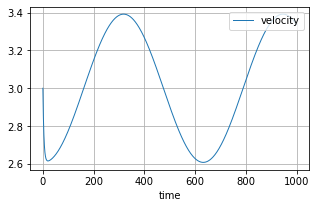

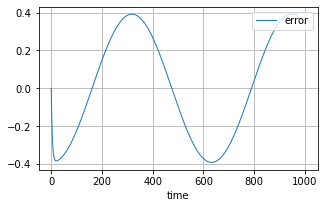

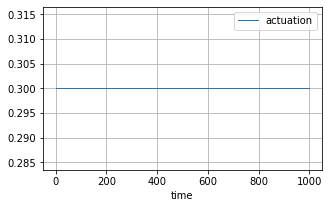

In [3]:
# define the reference signal
def r(t):
    return 3 # + np.sin( 0.1 * t )
    # if you want to try other signals, you may try default functions like
    # np.sin( c * t )
    # and combining with "if / then" statements, e.g.
    # if t < 0:
    #   return 2
    # else:
    #   return 3

# define the controller
def u(t):
    #
    # find the derivative numerically
    eps = 0.00000000001
    rdot = ( r(t + eps) - r(t - eps) ) / (2 * eps)
    #
    return m * rdot + b * r(t)

# define the initial condition (note: as a row vector)
X0 = [ 0, r(0) ]

# solve the ODE
X = odeint( myModel, X0, T )

# compute the error and actuation
ee = np.zeros( n )
uu = np.zeros( n )
for i, t in enumerate( T ):
    ee[i] = X[i,1] - r(t) # remember that X computed in this way is [pos, vel]
    uu[i] = u(t)

# plot the trajectory of the system
plt.figure()
fig_vel, ax_vel = plt.subplots(figsize=(5, 3))
fig_err, ax_err = plt.subplots(figsize=(5, 3))
fig_act, ax_act = plt.subplots(figsize=(5, 3))
#
ax_vel.plot(T, X[:,1], label='velocity',  linewidth=1)
ax_err.plot(T, ee,     label='error',     linewidth=1)
ax_act.plot(T, uu,     label='actuation', linewidth=1)
#
ax_vel.grid()
ax_vel.legend(loc = 'upper right')
ax_vel.set_xlabel('time')
ax_err.grid()
ax_err.legend(loc = 'upper right')
ax_err.set_xlabel('time')
ax_act.grid()
ax_act.legend(loc = 'upper right')
ax_act.set_xlabel('time')
#
plt.show()


## Assignments

A1. test what happens if $d(x) = 0$, create the plots, and comment what you get plus why you get what you get.

A2. test what happens if $d(x) \neq 0$, create the plots, and comment what you get plus why you get what you get.

A3. say why the line of code

`rdot = ( r(t + eps) - r(t - eps) ) / (2 * eps)`

makes this specific controller not implementable in real life.

## Closed loop control

With the aim of accounting for the error, we instead now try a different controller for which the engine torque is a function of the error, i.e.,

\begin{equation}
    u(t) = K e(t) = K \big( r(t) - y(t) \big)
\end{equation}

with $K$ a design parameter whose physical intuition may be summarized in "the higher $K$ is, the more the engine will react to an error".

<Figure size 432x288 with 0 Axes>

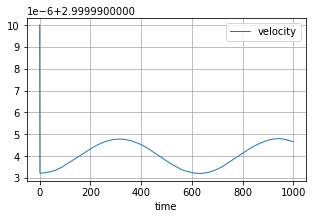

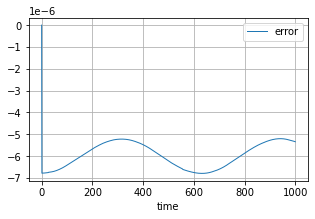

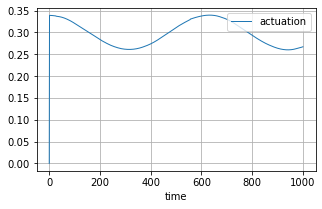

In [4]:
# define the reference signal
def r(t):
    return 3
    # if you want to try other signals, you may try default functions like
    # np.sin( c * t )
    # and combining with "if / then" statements, e.g.
    # if t < 0:
    #   return 2
    # else:
    #   return 3

# define the controller
def u(t, x1):
    #
    # define the proportional gain
    K = 50000
    #
    return K * ( r(t) - x1 )

# redefine the dynamics (necessary because the signature of u has changed)
def myModel(X, t):
    #
    # to aid readability of the code, get the individual variables
    x0 = X[0] # this is the position x(t)
    x1 = X[1] # this is \dot{x}(t)
    #
    # compute the individual derivatives as in the ODE above
    dx0dt  = x1
    dx1dt  = - (b / m) * x1 + (1 / m) * u(t, x1) - g * np.sin(d(t))
#   dx1dt  = - (b / m) * x1 + (1 / m) * u(t, x1) - g * np.sin(d(x0))
    #
    return [ dx0dt, dx1dt ]

# define the initial condition (note: as a row vector)
X0 = [ 0, r(0) ]

# solve the ODE
X = odeint( myModel, X0, T )

# compute the error and actuation signals
ee = np.zeros( n )
uu = np.zeros( n )
for i, t in enumerate( T ):
    ee[i] = X[i,1] - r(t) # remember that X computed in this way is [pos, vel]
    uu[i] = u(t, X[i,1])

# plot the trajectory of the system
plt.figure()
fig_vel, ax_vel = plt.subplots(figsize=(5, 3))
fig_err, ax_err = plt.subplots(figsize=(5, 3))
fig_act, ax_act = plt.subplots(figsize=(5, 3))
#
ax_vel.plot(T, X[:,1], label='velocity',  linewidth=1)
ax_err.plot(T, ee,     label='error',     linewidth=1)
ax_act.plot(T, uu,     label='actuation', linewidth=1)
#
ax_vel.grid()
ax_vel.legend(loc = 'upper right')
ax_vel.set_xlabel('time')
ax_err.grid()
ax_err.legend(loc = 'upper right')
ax_err.set_xlabel('time')
ax_act.grid()
ax_act.legend(loc = 'upper right')
ax_act.set_xlabel('time')
#
plt.show()


## Assignments

A4. compare the performance of the closed loop controller against the ones of the open loop controller for a $d(x) \neq 0$ that was making the open loop controller perform badly. Say what is happening, and why.

A5. Now try to change the gain $K$, and say how the error and the actuation signals qualitatively change as one increases or decreases this gain.

# The purpose of this course, in a nutshell

**Understand why the closed loop controller above performs better than the open loop one, and understand how to design even better controllers than the one you just implemented.**